4) For the real instances, WELL-01.csv and WELL-02.csv, compute for each variable (P-PDG, P-TPT, T-TPT) of each class (0 and 2) the Binary Pattern (BP). For this, for each instance, you will split the multivariate time series into two parts: the data labeled as class 0 and the data labeled as class 2. 
After, compute for each variable of each class the BP with n = 5 (each histogram will have 16 bins). Show the normalized histogram of each variable of each class of each instance (for each instance will have 3 histograms for each class (a total of 12 histograms). Use the subplot function to become the visualization easier. Analyze the obtained histograms and check if it is possible to distinguish the classes by the histograms and if the behavior of the classes is consistent in the two instances. Comment on your observations.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Definição das colunas de interesse
columns = ['Timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'class']

well_1 = pd.read_csv(r'C:\Users\USER\Desktop\GitHub\Universidade-time-series\Dataset\WELL-01.csv', delimiter=',', usecols=columns)
well_2 = pd.read_csv(r'C:\Users\USER\Desktop\GitHub\Universidade-time-series\Dataset\WELL-02.csv', delimiter=',', usecols=columns)

well_1 = [well_1[well_1['class']==0], well_1[well_1['class']==2]]
well_2 = [well_2[well_2['class']==0], well_2[well_2['class']==2]]
files = [well_1, well_2]

def bin_pattern(bloco, array):
    """
    Calcula o padrão binário de um array com base em um bloco de tamanho n.
    
    Parâmetros:
    - bloco (int): Tamanho do bloco (deve ser um inteiro ímpar maior que 1).
    - series (array-like): Série de valores numéricos.

    Retorno:
    - np.array: Array de padrões binários.
    
    Lança:
    - ValueError: Se `n` não for um número ímpar maior que 1.
    """
    if not isinstance(bloco, int) or bloco <= 1 or bloco % 2 == 0:
        raise ValueError("O tamanho do bloco deve ser um inteiro ímpar maior que 1.")
    
    array = np.asarray(array)  # Garante que seja um array NumPy
    gap =bloco // 2  # Define a quantidade de deslocamento baseado no tamanho do bloco
    pattern_list = np.zeros(len(array) - (2 * gap), dtype=int)
    vizinhos = list(range(1, gap + 1)) + list(range(-gap, 0))
    for i in range(gap, len(array) - gap):
        pattern = 0
        for bit,vizinho in enumerate(vizinhos):  # Atribui pesos binários
            if array[i + vizinho] >= array[i]:
                pattern += 2 ** bit
        pattern_list[i - gap] = pattern  # Salva o padrão na posição correspondente

    return pattern_list

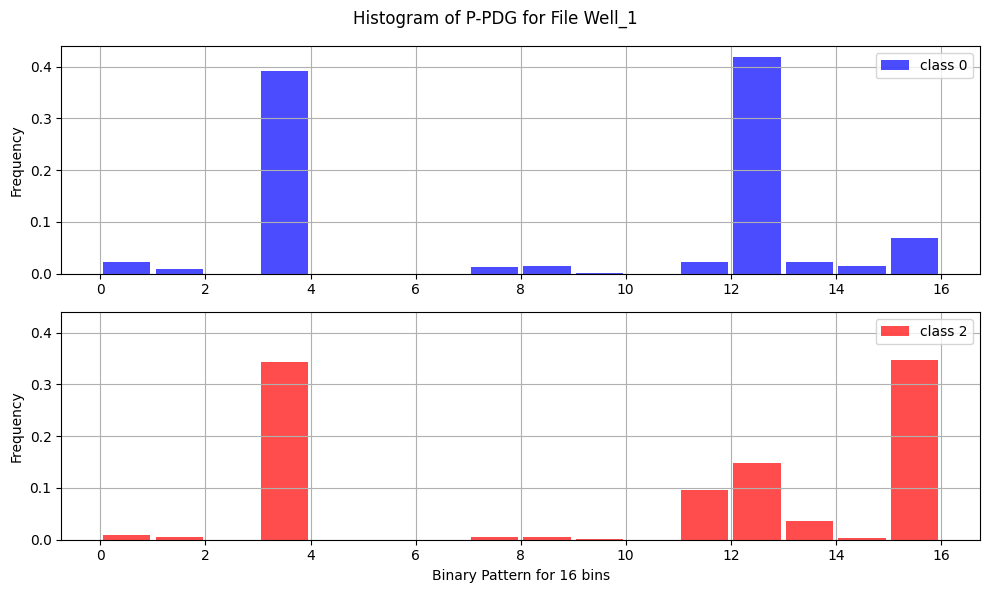

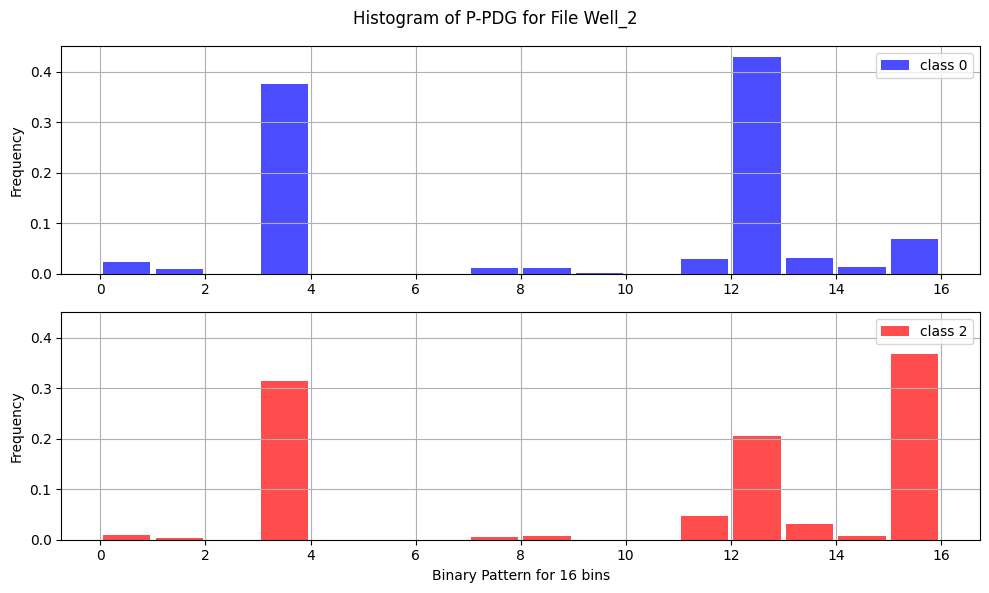

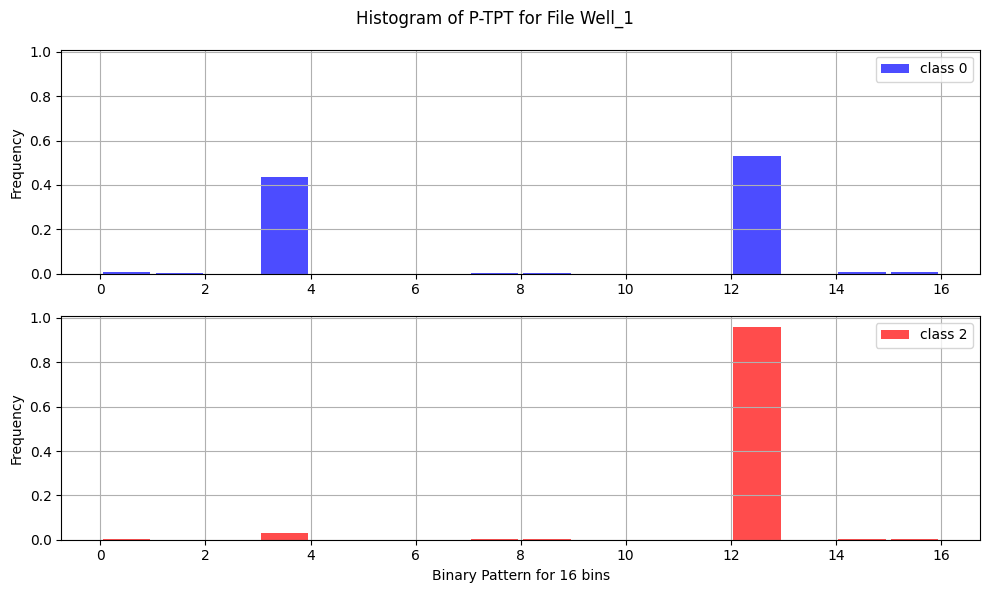

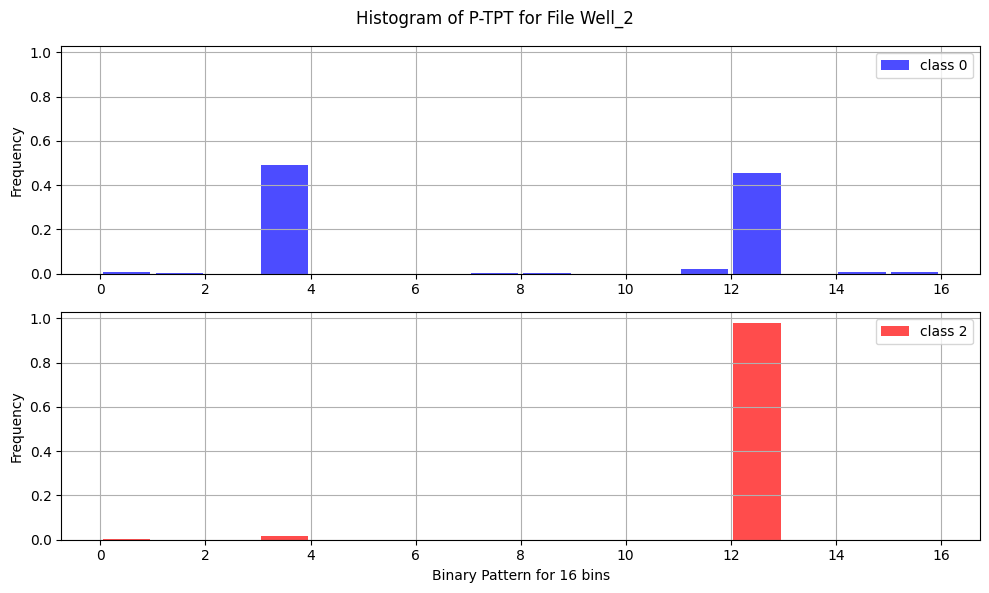

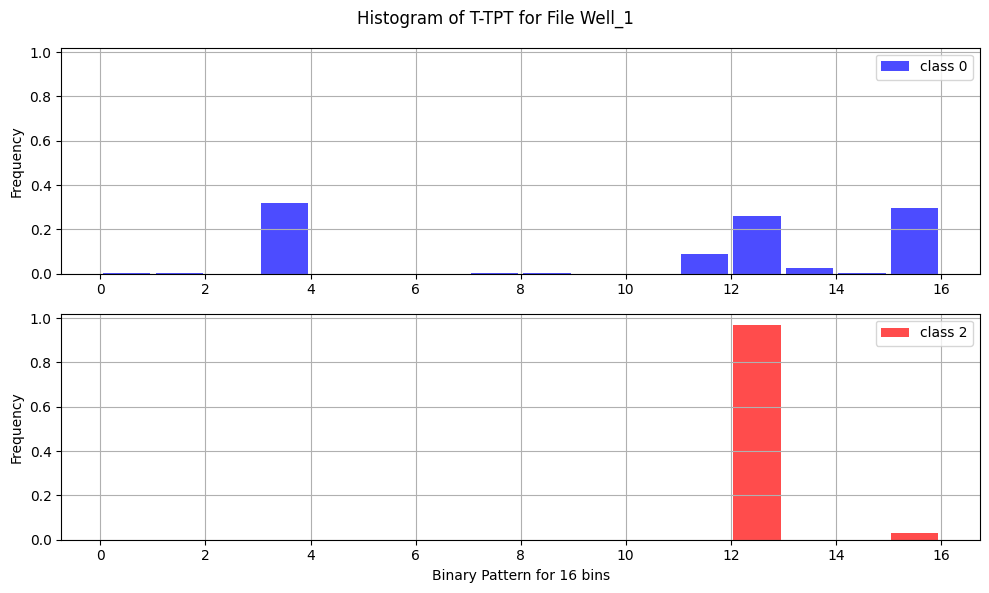

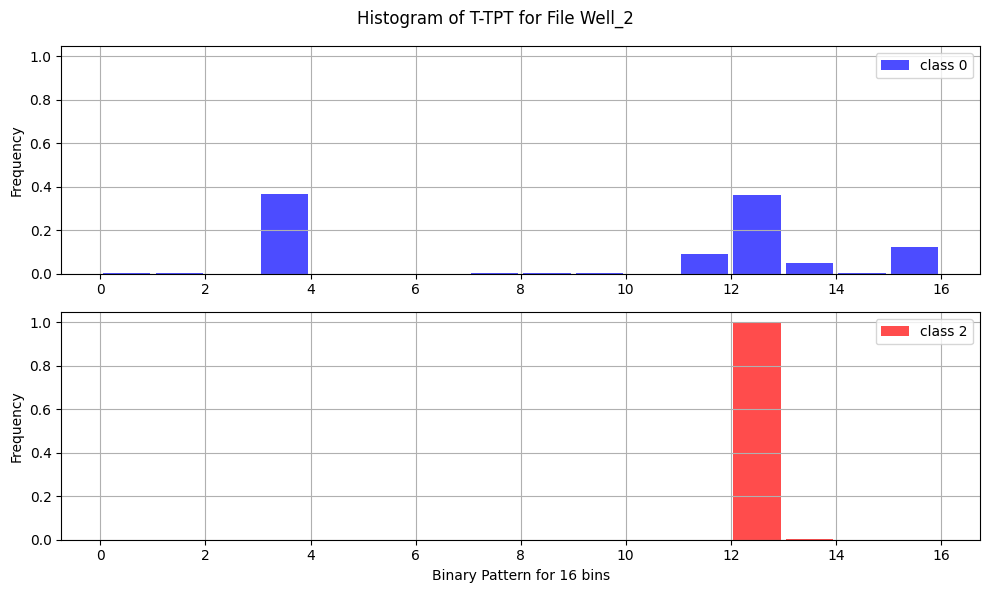

In [2]:
variables = ['P-PDG', 'P-TPT', 'T-TPT']
file_names = ['Well_1', 'Well_2']

for variable in variables:
    for id, df in enumerate(files):
        BP0 = bin_pattern(5, df[0][variable])
        BP2 = bin_pattern(5, df[1][variable])

        # normalização e para comparação de graficos de cada uma das classes com a mesma escala
        cont0,_ = np.histogram(BP0, bins=16)
        cont2,_ = np.histogram(BP2, bins=16)
        maxcount = max(max(cont0)/len(BP0), max(cont2)/len(BP2))

        fig = plt.figure(figsize=(10, 6))
        fig.suptitle(f'Histogram of {variable} for File {file_names[id]}')

        plt.subplot(2, 1, 1)
        plt.hist(BP0, bins=np.arange(17), rwidth=0.9,density=True, label='class 0', alpha=0.7, color='blue')
        plt.ylim(0, maxcount *1.05)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid()

        plt.subplot(2, 1, 2)
        plt.hist(BP2, bins=np.arange(17), rwidth=0.9,density=True, label='class 2', alpha=0.7, color='red')
        plt.ylim(0, maxcount *1.05)
        plt.ylabel('Frequency')
        plt.xlabel('Binary Pattern for 16 bins')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

5) Use kNN (k-nearest neighbors) and the simulated instances to classify the real ones. For each simulated instance, use a sliding window of length equal to 100 (without overlapping) in each variable (P-PDG, P-TPT, T-TPT) to compute the features: mean, standard deviation, mean increase, mean decrease, standard deviation differences, and mean absolute differences (each data window will be represented by a vector of 6x3 = 18 features). For each vector, you must associate the most predominant class in the data window. These vectors will be the training set of the kNN classifier. Perform the same procedure in real instances to obtain their feature vectors. These vectors will be the test set. Standardize the data (training and test sets), that is, apply for each element of each vector the equation below, where the mean and standard deviation are obtained from the training set for each feature. Use kNN, with k = 1, to classify the test set. Evaluate the classification performance using the accuracy metric. You can use the sklearn.neighbors.KNeighborsClassifier function in Python, or fitcknn in Matlab.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

colums = ['Timestamp','P-PDG','P-TPT','T-TPT','class']
path = r'C:\Users\USER\Desktop\GitHub\Universidade-time-series\Dataset'

d1 = pd.read_csv(path + '\\SIM-01.csv',index_col=False, delimiter=',',header=0,usecols=colums)
d2 = pd.read_csv(path + '\\SIM-02.csv',index_col=False, delimiter=',',header=0,usecols=colums)
d3 = pd.read_csv(path + '\\SIM-03.csv',index_col=False, delimiter=',',header=0,usecols=colums)
d4 = pd.read_csv(path + '\\SIM-04.csv',index_col=False, delimiter=',',header=0,usecols=colums)
d5 = pd.read_csv(path + '\\SIM-05.csv',index_col=False, delimiter=',',header=0,usecols=colums)
w1 = pd.read_csv(path + '\\WELL-01.csv',index_col=False, delimiter=',',header=0,usecols=colums)
w2 = pd.read_csv(path + '\\WELL-01.csv',index_col=False, delimiter=',',header=0,usecols=colums)

def class_data(data):
    """
    Cria um vetor de classe baseado na média da coluna 'class' 
    em janelas móveis de tamanho 100.
    
    Parâmetros:
        data (pd.DataFrame): DataFrame contendo a coluna 'class'.
    
    Retorna:
        np.ndarray: Vetor de classes (0 ou 2) com base na média das janelas móveis.
    """
    aux = data.copy()  # Evita modificar o DataFrame original
    window_size = 100
    num_samples = len(aux) - window_size
    cl = np.empty(num_samples, dtype=int)  # Vetor de classes

    for ni, i in enumerate(range(window_size, len(aux))):  
        aux2 = aux.iloc[ni:i]  # Janela móvel
        cl[ni] = 0 if aux2['class'].mean() <= 1 else 2  

    return cl

def features(data, inst):
    """
    Extrai 6 features estatísticas de uma janela móvel de 100 amostras.

    Parâmetros:
        data (pd.DataFrame): DataFrame contendo os dados.
        inst (int): Índice da variável a ser usada nas features.

    Retorna:
        np.ndarray: Matriz com as 6 features extraídas.
    """
    aux = data.copy()
    window_size = 100
    num_samples = len(aux) - window_size
    nm = ['P-PDG', 'P-TPT', 'T-TPT']
    column = nm[inst]

    # Inicializa a matriz de features (6 colunas)
    mt_feat = np.zeros((num_samples, 6))
    values = aux[column].values  # Converte a coluna para um array NumPy para maior eficiência

    # Cálculo de média e desvio padrão (features 0 e 1)
    for ni, i in enumerate(range(window_size, len(aux))):
        window = values[ni:i]
        mt_feat[ni, 0] = np.mean(window)  # Média
        mt_feat[ni, 1] = np.std(window)   # Desvio padrão

    # Cálculo de incremento médio, decremento médio, desvio absoluto médio e desvio padrão das diferenças
    udif = np.zeros(num_samples)  # Mean diff

    for i in range(num_samples):
        si, ci, sd, cd, mad, sf, xp = 0, 0, 0, 0, 0, 0, 0

        for k in range(i, i + window_size - 1):
            diff = values[k + 1] - values[k]
            mad += abs(diff)

            if diff > 0:
                si += diff
                ci += 1
            elif diff < 0:
                sd -= diff  # Já somando com valor positivo
                cd += 1

            sf += diff

        # Feature 5: Mean Absolute Difference (MAD)
        mt_feat[i, 5] = mad / (window_size - 1)

        # Feature 2: Mean Increase
        mt_feat[i, 2] = si / ci if ci else 0

        # Feature 3: Mean Decrease
        mt_feat[i, 3] = sd / cd if cd else 0

        # Feature 4: Standard Deviation of Differences
        udif[i] = sf / (window_size - 1)
        for k in range(i, i + window_size - 2):
            xp += (values[k + 1] - values[k] - udif[i]) ** 2
        mt_feat[i, 4] = np.sqrt(xp / (window_size - 2))

    return mt_feat

# Função para extrair features e classes
def extract_features_and_classes(datasets):
    features_list = [np.hstack([features(data, i) for i in range(3)]) for data in datasets]
    class_list = [class_data(data) for data in datasets]
    return np.vstack(features_list), np.hstack(class_list)

# Definição dos conjuntos de treino e teste
D, Dclass = extract_features_and_classes([d1, d2, d3, d4, d5])
W, Wclass = extract_features_and_classes([w1, w2])

# Criação dos DataFrames
D_df = pd.DataFrame(D, columns=[str(i+1) for i in range(D.shape[1])])
D_class_df = pd.DataFrame({'D_class': Dclass})

W_df = pd.DataFrame(W, columns=[str(i+1) for i in range(W.shape[1])])
W_class_df = pd.DataFrame({'W_class': Wclass})

# Padronização (Z-score normalization)
mean_train = D_df.mean()
std_train = D_df.std()

D_normalized = (D_df - mean_train) / std_train
W_normalized = (W_df - mean_train) / std_train

# Treinamento e avaliação do modelo KNN
knn = KNeighborsClassifier(n_neighbors=1)

print('Before Z-score')
knn.fit(D_df, D_class_df.values.ravel())
print(classification_report(W_class_df, knn.predict(W_df)))

print('After Z-score')
knn.fit(D_normalized, D_class_df.values.ravel())
print(classification_report(W_class_df, knn.predict(W_normalized)))

Before Z-score


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7250
           2       0.34      1.00      0.51      3750

    accuracy                           0.34     11000
   macro avg       0.17      0.50      0.25     11000
weighted avg       0.12      0.34      0.17     11000

After Z-score
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7250
           2       0.91      1.00      0.95      3750

    accuracy                           0.97     11000
   macro avg       0.95      0.97      0.96     11000
weighted avg       0.97      0.97      0.97     11000

